In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 919)
(466039, 1)
validation
(80707, 919)
(80707, 1)
test
(46831, 919)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 55s - loss: 0.0491 - STD: 2.0538e-04 - MAE: 0.2115

 4/47 [=>............................] - ETA: 0s - loss: 0.0325 - STD: 2.9656e-04 - MAE: 0.1336 

 7/47 [===>..........................] - ETA: 0s - loss: 0.0310 - STD: 2.6187e-04 - MAE: 0.1242

10/47 [=====>........................] - ETA: 0s - loss: 0.0271 - STD: 2.9439e-04 - MAE: 0.1147

13/47 [=======>......................] - ETA: 0s - loss: 0.0260 - STD: 3.4847e-04 - MAE: 0.1185

16/47 [=========>....................] - ETA: 0s - loss: 0.0244 - STD: 3.9695e-04 - MAE: 0.1145

19/47 [===========>..................] - ETA: 0s - loss: 0.0235 - STD: 4.3336e-04 - MAE: 0.1084

22/47 [=============>................] - ETA: 0s - loss: 0.0227 - STD: 4.6986e-04 - MAE: 0.1038

25/47 [==============>...............] - ETA: 0s - loss: 0.0221 - STD: 5.1742e-04 - MAE: 0.1013

28/47 [================>.............] - ETA: 0s - loss: 0.0216 - STD: 5.7559e-04 - MAE: 0.1013

31/47 [==================>...........] - ETA: 0s - loss: 0.0212 - STD: 6.3786e-04 - MAE: 0.1012

34/47 [====================>.........] - ETA: 0s - loss: 0.0208 - STD: 6.9937e-04 - MAE: 0.0997

37/47 [======================>.......] - ETA: 0s - loss: 0.0206 - STD: 7.6563e-04 - MAE: 0.0982

38/47 [=======================>......] - ETA: 0s - loss: 0.0205 - STD: 7.9015e-04 - MAE: 0.0977

41/47 [=========================>....] - ETA: 0s - loss: 0.0203 - STD: 8.7655e-04 - MAE: 0.0967

44/47 [===========================>..] - ETA: 0s - loss: 0.0200 - STD: 9.8422e-04 - MAE: 0.0964

47/47 [==============================] - ETA: 0s - loss: 0.0198 - STD: 0.0011 - MAE: 0.0961    

47/47 [==============================] - 3s 48ms/step - loss: 0.0198 - STD: 0.0011 - MAE: 0.0961 - val_loss: 0.0153 - val_STD: 0.0025 - val_MAE: 0.0735


Epoch 2/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0162 - STD: 0.0033 - MAE: 0.0861

 5/47 [==>...........................] - ETA: 0s - loss: 0.0163 - STD: 0.0038 - MAE: 0.0822

 8/47 [====>.........................] - ETA: 0s - loss: 0.0163 - STD: 0.0043 - MAE: 0.0822

11/47 [======>.......................] - ETA: 0s - loss: 0.0162 - STD: 0.0050 - MAE: 0.0836

14/47 [=======>......................] - ETA: 0s - loss: 0.0161 - STD: 0.0059 - MAE: 0.0843

17/47 [=========>....................] - ETA: 0s - loss: 0.0159 - STD: 0.0069 - MAE: 0.0837

20/47 [===========>..................] - ETA: 0s - loss: 0.0157 - STD: 0.0082 - MAE: 0.0829

23/47 [=============>................] - ETA: 0s - loss: 0.0154 - STD: 0.0100 - MAE: 0.0823

26/47 [===============>..............] - ETA: 0s - loss: 0.0151 - STD: 0.0124 - MAE: 0.0816

29/47 [=================>............] - ETA: 0s - loss: 0.0147 - STD: 0.0153 - MAE: 0.0803

32/47 [===================>..........] - ETA: 0s - loss: 0.0143 - STD: 0.0191 - MAE: 0.0791

34/47 [====================>.........] - ETA: 0s - loss: 0.0140 - STD: 0.0219 - MAE: 0.0781

36/47 [=====================>........] - ETA: 0s - loss: 0.0136 - STD: 0.0249 - MAE: 0.0771

39/47 [=======================>......] - ETA: 0s - loss: 0.0131 - STD: 0.0298 - MAE: 0.0756

41/47 [=========================>....] - ETA: 0s - loss: 0.0128 - STD: 0.0329 - MAE: 0.0747

43/47 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 0.0359 - MAE: 0.0737

46/47 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 0.0402 - MAE: 0.0723

47/47 [==============================] - 1s 26ms/step - loss: 0.0120 - STD: 0.0414 - MAE: 0.0718 - val_loss: 0.0049 - val_STD: 0.0689 - val_MAE: 0.0459


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.1057 - MAE: 0.0510

 4/47 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.1054 - MAE: 0.0498

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.1067 - MAE: 0.0493

 9/47 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.1073 - MAE: 0.0489

11/47 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.1078 - MAE: 0.0486

14/47 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.1084 - MAE: 0.0479

17/47 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.1093 - MAE: 0.0474

20/47 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.1093 - MAE: 0.0468

23/47 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.1097 - MAE: 0.0463

26/47 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.1103 - MAE: 0.0458

29/47 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.1110 - MAE: 0.0455

32/47 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.1112 - MAE: 0.0451

34/47 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.1117 - MAE: 0.0449

36/47 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.1119 - MAE: 0.0446

38/47 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.1123 - MAE: 0.0444

41/47 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.1125 - MAE: 0.0441

44/47 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.1128 - MAE: 0.0438

47/47 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.1132 - MAE: 0.0436

47/47 [==============================] - 1s 27ms/step - loss: 0.0041 - STD: 0.1132 - MAE: 0.0436 - val_loss: 0.0041 - val_STD: 0.0937 - val_MAE: 0.0415


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.1147 - MAE: 0.0389

 4/47 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.1165 - MAE: 0.0395

 6/47 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1166 - MAE: 0.0395

 9/47 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.1167 - MAE: 0.0395

11/47 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.1168 - MAE: 0.0394

14/47 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.1174 - MAE: 0.0393

17/47 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.1176 - MAE: 0.0392

20/47 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.1177 - MAE: 0.0392

22/47 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.1175 - MAE: 0.0392

25/47 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.1177 - MAE: 0.0391

28/47 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1179 - MAE: 0.0389

30/47 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1179 - MAE: 0.0389

32/47 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.1181 - MAE: 0.0388

34/47 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1180 - MAE: 0.0388

37/47 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1180 - MAE: 0.0386

40/47 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.1179 - MAE: 0.0386

42/47 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1179 - MAE: 0.0385

45/47 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1179 - MAE: 0.0384

47/47 [==============================] - 1s 30ms/step - loss: 0.0030 - STD: 0.1180 - MAE: 0.0384 - val_loss: 0.0037 - val_STD: 0.0984 - val_MAE: 0.0380


Epoch 5/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1198 - MAE: 0.0370

 3/47 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1200 - MAE: 0.0365

 5/47 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1194 - MAE: 0.0366

 8/47 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0366

10/47 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0365

12/47 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0365

15/47 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0365

18/47 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0365

21/47 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0365

23/47 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.1190 - MAE: 0.0364

25/47 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1189 - MAE: 0.0364

27/47 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0364

29/47 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0363

31/47 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0363

33/47 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0364

35/47 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0363

38/47 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0364

41/47 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0363

44/47 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1192 - MAE: 0.0363

46/47 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1191 - MAE: 0.0363

47/47 [==============================] - 2s 32ms/step - loss: 0.0027 - STD: 0.1193 - MAE: 0.0363 - val_loss: 0.0037 - val_STD: 0.0937 - val_MAE: 0.0396


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.1148 - MAE: 0.0370

 3/47 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1211 - MAE: 0.0363

 6/47 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1202 - MAE: 0.0362

 8/47 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.1195 - MAE: 0.0360

11/47 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.1197 - MAE: 0.0359

13/47 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0358

16/47 [=========>....................] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0357

19/47 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1202 - MAE: 0.0357

21/47 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0356

24/47 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1196 - MAE: 0.0355

26/47 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1198 - MAE: 0.0354

29/47 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0353

32/47 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1201 - MAE: 0.0352

34/47 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1200 - MAE: 0.0352

37/47 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0351

40/47 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0350

42/47 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1200 - MAE: 0.0350

45/47 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1199 - MAE: 0.0349

47/47 [==============================] - 1s 29ms/step - loss: 0.0025 - STD: 0.1199 - MAE: 0.0349 - val_loss: 0.0034 - val_STD: 0.1010 - val_MAE: 0.0367


Epoch 7/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1255 - MAE: 0.0344

 3/47 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1228 - MAE: 0.0341

 5/47 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1225 - MAE: 0.0344

 8/47 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1220 - MAE: 0.0344

11/47 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.1215 - MAE: 0.0344

14/47 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1214 - MAE: 0.0344

16/47 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.1213 - MAE: 0.0343

18/47 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

20/47 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1208 - MAE: 0.0342

22/47 [=============>................] - ETA: 0s - loss: 0.0024 - STD: 0.1209 - MAE: 0.0342

24/47 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

27/47 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

29/47 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

31/47 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

33/47 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0341

35/47 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0340

37/47 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1205 - MAE: 0.0341

40/47 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0340

43/47 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0340

46/47 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1206 - MAE: 0.0339

47/47 [==============================] - 1s 30ms/step - loss: 0.0024 - STD: 0.1207 - MAE: 0.0339 - val_loss: 0.0035 - val_STD: 0.0959 - val_MAE: 0.0376


Epoch 8/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0330

 4/47 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0332

 6/47 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0332

 8/47 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.1215 - MAE: 0.0333

10/47 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

12/47 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0335

15/47 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0335

18/47 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1206 - MAE: 0.0334

21/47 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0333

24/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0333

27/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333

30/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0332

36/47 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

38/47 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0332

41/47 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1211 - MAE: 0.0332

44/47 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333

47/47 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333

47/47 [==============================] - 1s 30ms/step - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333 - val_loss: 0.0039 - val_STD: 0.0912 - val_MAE: 0.0407


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.1156 - MAE: 0.0349

 3/47 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1202 - MAE: 0.0338

 5/47 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0336

 7/47 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0333

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0333

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1220 - MAE: 0.0332

16/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1219 - MAE: 0.0331

19/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1217 - MAE: 0.0331

22/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0330

24/47 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0329

27/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0329

30/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0328

33/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0328

36/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0328

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1212 - MAE: 0.0328

41/47 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1213 - MAE: 0.0328

44/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0327

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0328

47/47 [==============================] - 1s 28ms/step - loss: 0.0022 - STD: 0.1215 - MAE: 0.0328 - val_loss: 0.0041 - val_STD: 0.0902 - val_MAE: 0.0422


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.1122 - MAE: 0.0356

 4/47 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1193 - MAE: 0.0336

 6/47 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1207 - MAE: 0.0341

 8/47 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0337

10/47 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0336

13/47 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0337

15/47 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.1207 - MAE: 0.0335

17/47 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.1210 - MAE: 0.0335

20/47 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1209 - MAE: 0.0334

23/47 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1208 - MAE: 0.0333

26/47 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1212 - MAE: 0.0332

28/47 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0332

30/47 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0331

32/47 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.1214 - MAE: 0.0331

34/47 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1213 - MAE: 0.0330

36/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0329

38/47 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0329

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0328

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0328

46/47 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0328

47/47 [==============================] - 1s 31ms/step - loss: 0.0022 - STD: 0.1215 - MAE: 0.0328 - val_loss: 0.0035 - val_STD: 0.0967 - val_MAE: 0.0380


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1209 - MAE: 0.0324

 4/47 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1210 - MAE: 0.0324

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0322

10/47 [=====>........................] - ETA: 0s - loss: 0.0022 - STD: 0.1214 - MAE: 0.0323

13/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0323

16/47 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0323

18/47 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0324

20/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0324

22/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0325

25/47 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0325

28/47 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.1215 - MAE: 0.0325

31/47 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0326

33/47 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0325

35/47 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0326

37/47 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0325

40/47 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0325

43/47 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1218 - MAE: 0.0325

45/47 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1216 - MAE: 0.0325

47/47 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1217 - MAE: 0.0325

47/47 [==============================] - 1s 30ms/step - loss: 0.0022 - STD: 0.1217 - MAE: 0.0325 - val_loss: 0.0034 - val_STD: 0.1004 - val_MAE: 0.0372


Epoch 12/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.1257 - MAE: 0.0333

 4/47 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1242 - MAE: 0.0327

 7/47 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.1224 - MAE: 0.0328

 9/47 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1222 - MAE: 0.0327

11/47 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1221 - MAE: 0.0325

14/47 [=======>......................] - ETA: 0s - loss: 0.0022 - STD: 0.1223 - MAE: 0.0324

17/47 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.1225 - MAE: 0.0323

20/47 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.1225 - MAE: 0.0322

23/47 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.1227 - MAE: 0.0321

26/47 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1226 - MAE: 0.0321

28/47 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0321

31/47 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1225 - MAE: 0.0320

33/47 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1224 - MAE: 0.0320

36/47 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1223 - MAE: 0.0320

39/47 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1222 - MAE: 0.0319

42/47 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0319

44/47 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0319

46/47 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0319

47/47 [==============================] - 1s 29ms/step - loss: 0.0021 - STD: 0.1221 - MAE: 0.0319 - val_loss: 0.0035 - val_STD: 0.0951 - val_MAE: 0.0383


Epoch 13/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1197 - MAE: 0.0315

 3/47 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1196 - MAE: 0.0315

 5/47 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1212 - MAE: 0.0320

 7/47 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.1216 - MAE: 0.0322

10/47 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.1217 - MAE: 0.0321

13/47 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1215 - MAE: 0.0320

16/47 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1216 - MAE: 0.0319

19/47 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0320

22/47 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0320

25/47 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0321

28/47 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0322

30/47 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1219 - MAE: 0.0322

32/47 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0323

35/47 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0322

37/47 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0321

40/47 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0322

43/47 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0321

45/47 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1221 - MAE: 0.0321

47/47 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1220 - MAE: 0.0321

47/47 [==============================] - 1s 30ms/step - loss: 0.0021 - STD: 0.1220 - MAE: 0.0321 - val_loss: 0.0035 - val_STD: 0.0993 - val_MAE: 0.0377


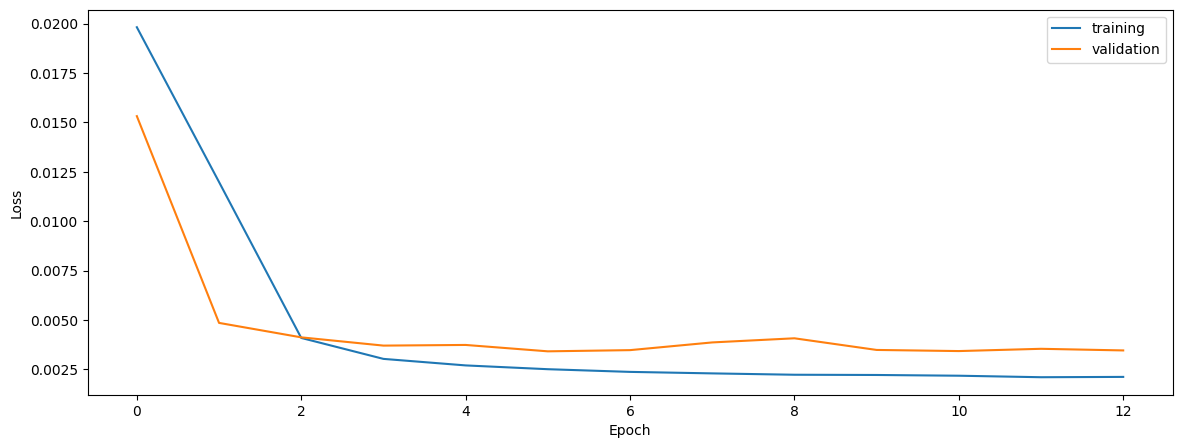

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9276171234013295
0.8885533486696076
0.9386547506155766


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9276171234013295
0.8885533486696076
0.9386547506155766


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9331929209778217
0.9025564066839831
0.9378696095998017


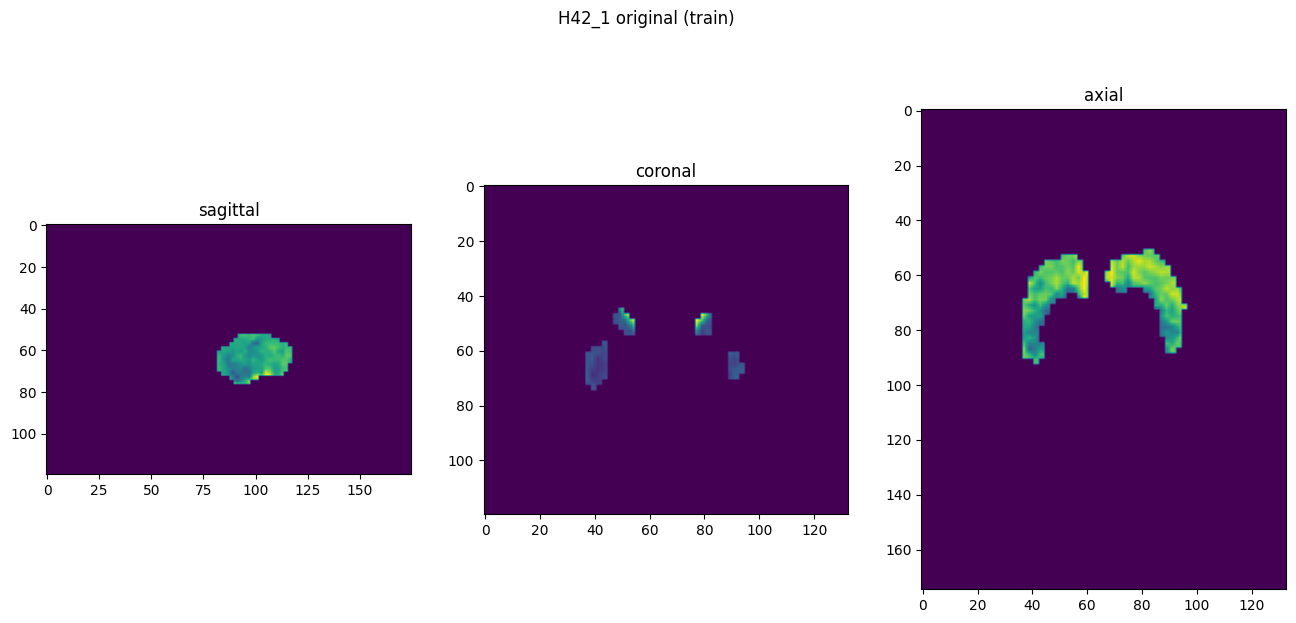

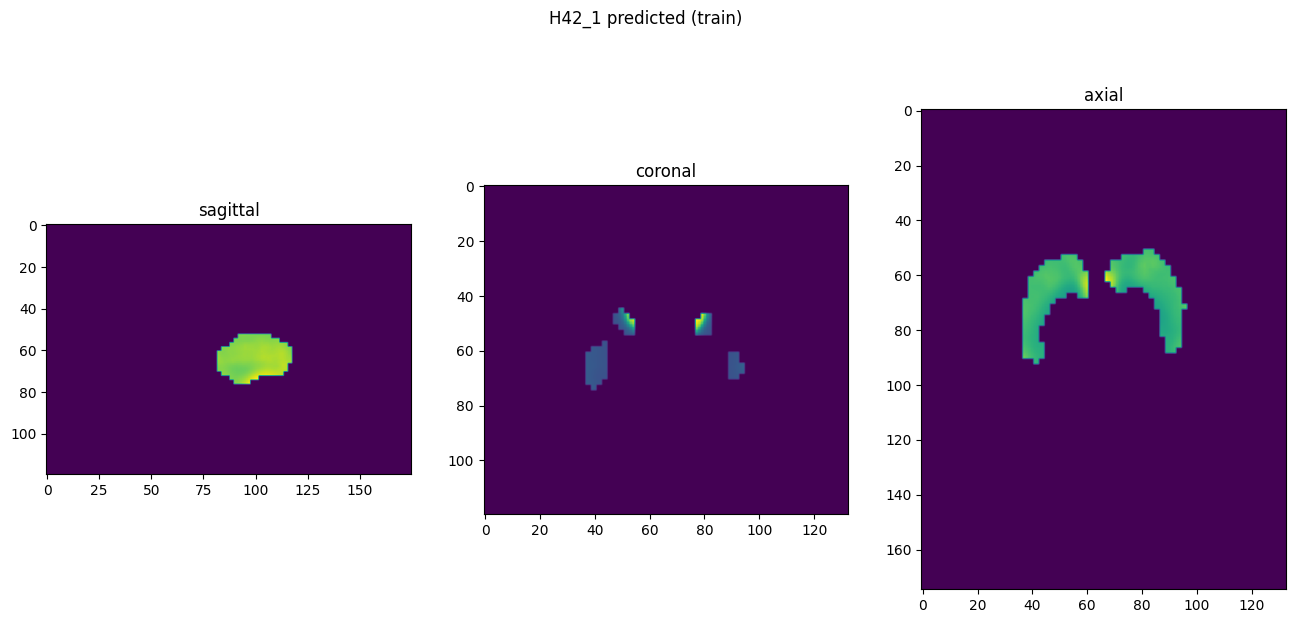

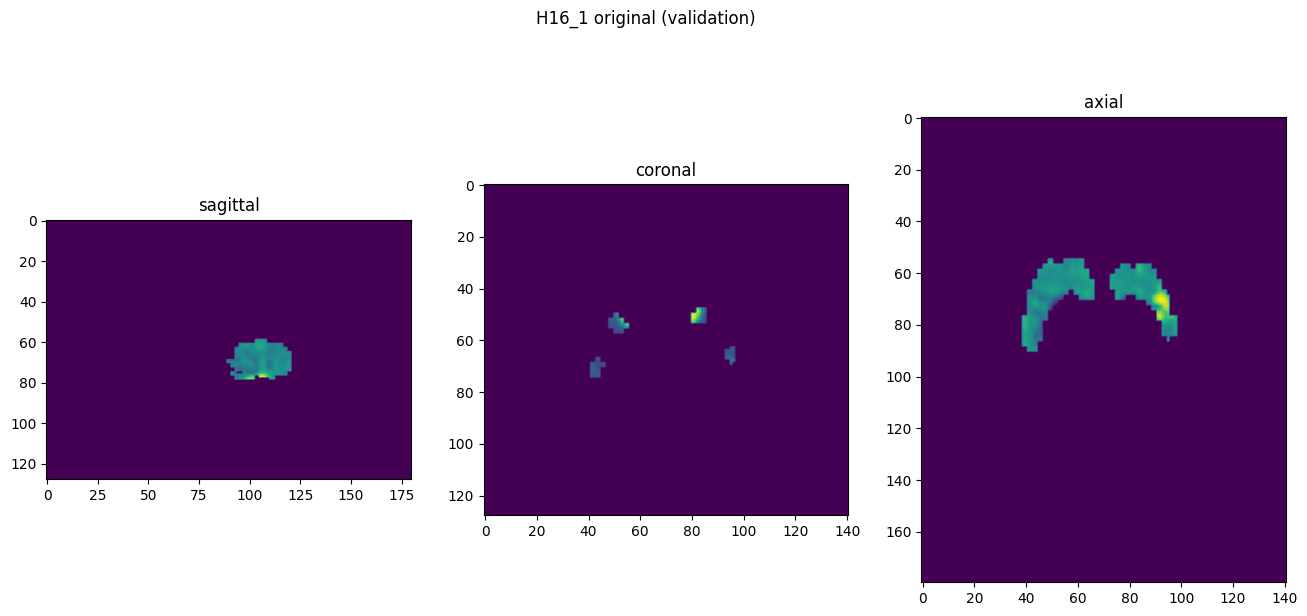

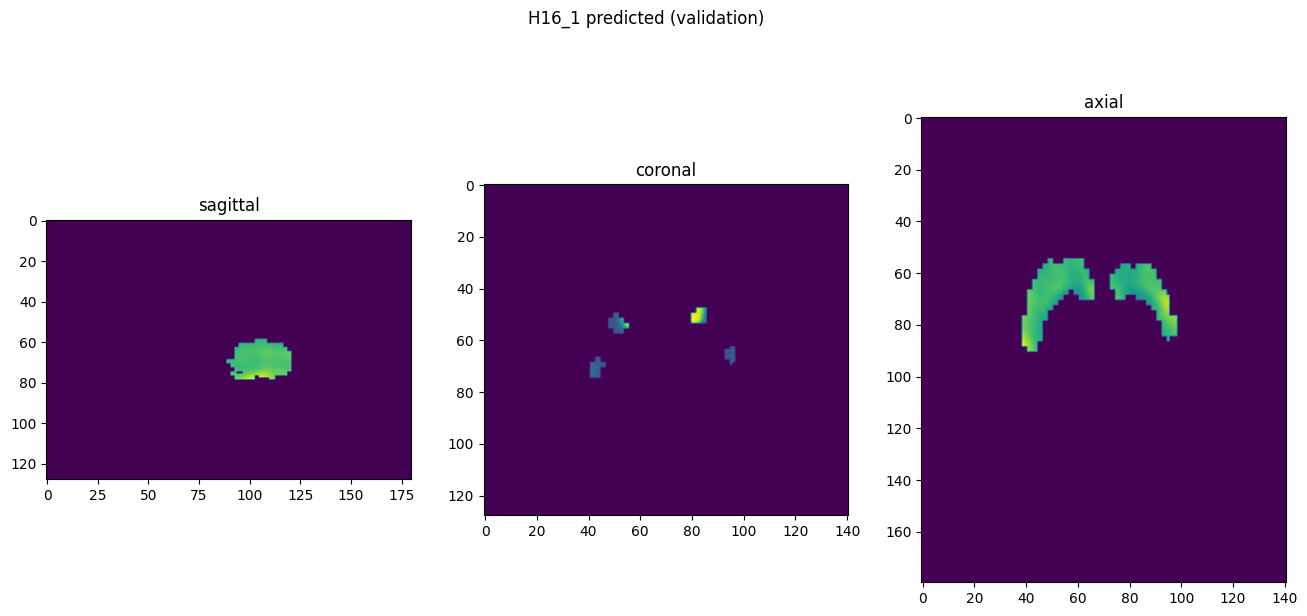

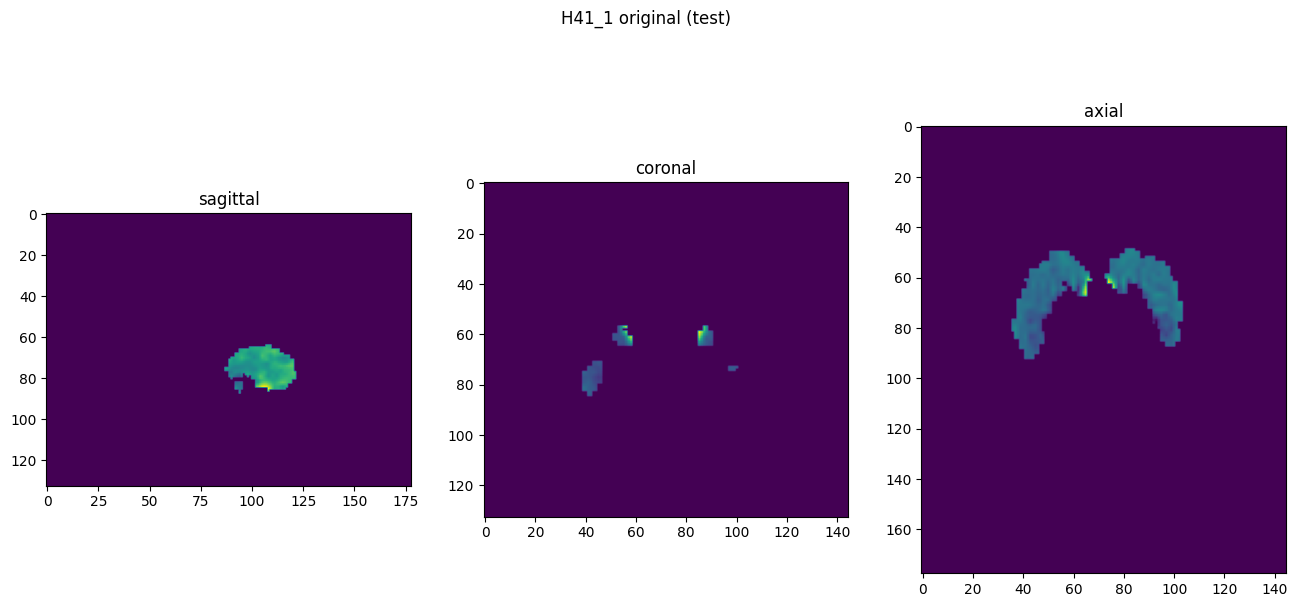

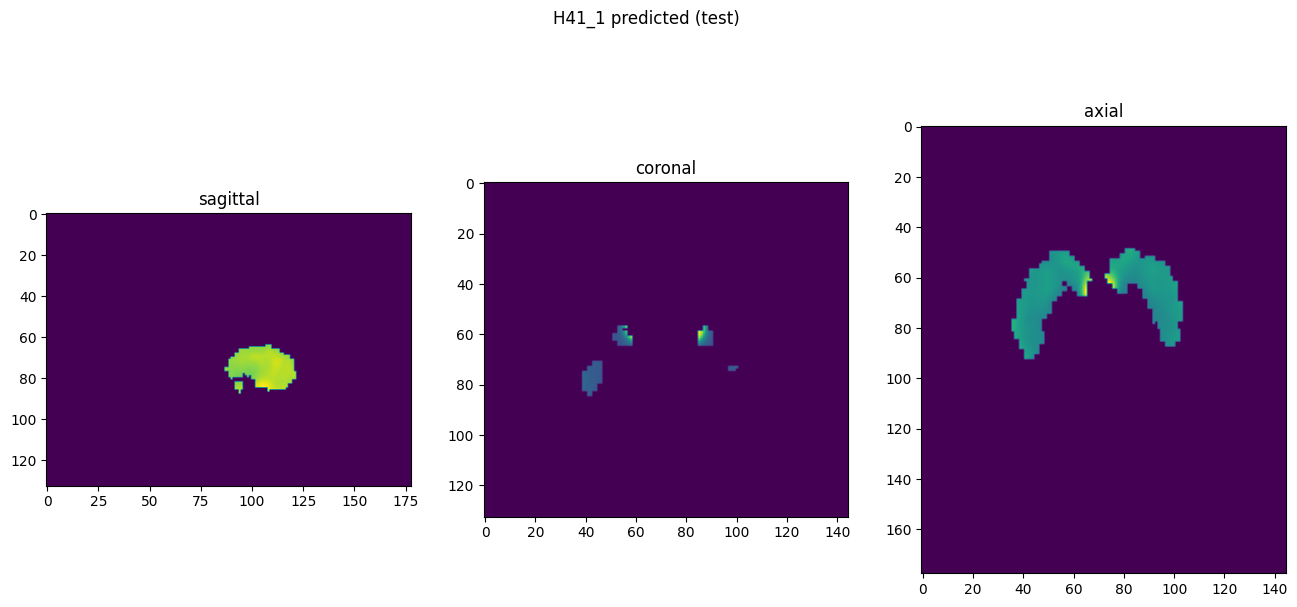

In [10]:
showResults(model, gen, threshold=None, background=False)